In [1]:
import numpy as np
import os
import contextlib
import pickle
import tqdm
from datasets.XP2 import Xp2Dataset
from datasets.utils import plot_on_topomap, select_grid_results_by_metric
import matplotlib.pyplot as plt
from datasets.mh_features import get_distance_matrix, correlation_distance
from models.efp import mh_grid_search, mh_common_model
from models.clustering import get_trained_model_on_cluster
import pandas as pd

import seaborn as sns

/home/riccardo/Projects/EEG-fMRI_fusion/models/clustering.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
#TODO Handle -bad- annotations if there are any
# root = '/home/cat/PycharmProjects/EEG-fMRI_fusion/data/XP2_derivatives_sample/'
base_folder = '/home/riccardo/MHdatasets'
stockwell_folder = '/media/storage1/stockwells'
out_folder = '/home/riccardo/MHdatasets/saves'
roi_str =  'sma'
window_type='kazemi'
gamma=15
fmax = 60
n_bands = 10
workers = 1

# base_folder = '/home/cat/Documents/'
root = os.path.join(base_folder,'XP2')
# dataset = Xp2Dataset(root, 'dataset.p')
# dataset = Xp2Dataset(root, os.path.join(base_folder,'dataset_MH_linux.p'))
dataset = Xp2Dataset(root, os.path.join(base_folder, f'dataset_MH_a{fmax}_{n_bands}_{window_type}_{gamma}.p'))
dataset.get_eeg_data(False)
dataset.get_mh_features_and_targets(nf_key_bold=('roimean', 'bgmean'), 
                                    fmax=fmax,
                                    n_bands=n_bands,
                                    overwrite=False,
                                    workers=workers,
                                    band_boundaries=None,
                                    save_folder=stockwell_folder,
                                    base_freq_grid_size=500,
                                    gamma=gamma,
                                    window_type=window_type, # kazemi, gauss
                                   )

Starting workers and distributing tasks...


Preparing features and targets...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 1089.98it/s]


In [3]:
dataset_unibands = Xp2Dataset(root, os.path.join(base_folder, f'dataset_MH_uniband_a{fmax}_{n_bands}_{window_type}_{gamma}.p'))
dataset_unibands.get_eeg_data(False)
shared_bands = dataset_unibands.get_dataset_shared_bands(fmax=fmax)
dataset_unibands.get_mh_features_and_targets(nf_key_bold=('roimean', 'bgmean'), 
                                    fmax=fmax,
                                    n_bands=n_bands,
                                    overwrite=False,
                                    workers=workers,
                                    band_boundaries=shared_bands,
                                    save_folder=stockwell_folder,
                                    base_freq_grid_size=500,
                                    gamma=gamma,
                                    window_type=window_type, # kazemi, gauss
                                            )

Effective window size : 10.240 (s)
Starting workers and distributing tasks...


Preparing features and targets...: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 1110.05it/s]


In [4]:
delay_time_seconds = 12 # 17.25
target_str = f'target_{roi_str}'
default_subject=1
subject=default_subject
test_ratio=.2
regularization_grid_search=50

In [5]:
all_grid_search_results_unibands, all_models_unibands, grouped_unibands = mh_grid_search(
    dataset_unibands, f'{out_folder}/all_grid_search_results_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}_samebands.p',
    f'{out_folder}/all_models_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}_samebands.p',
    target_str=target_str,
    test_ratio=test_ratio,
    delay_time_seconds=delay_time_seconds,
)

all_grid_search_results, all_models, grouped = mh_grid_search(
    dataset, f'{out_folder}/all_grid_search_results_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p',
    f'{out_folder}/all_models_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p',
    target_str=target_str,
    test_ratio=test_ratio,
    delay_time_seconds=delay_time_seconds,
)

Using order based on dataframe channel info
Using order based on dataframe channel info
Subjects:
[np.int64(1), np.int64(3), np.int64(4), np.int64(7), np.int64(12), np.int64(13), np.int64(14), np.int64(20), np.int64(37), np.int64(39), np.int64(43)]
len: 11, 25.0% of the total.
Max mean correlation channel: CPz
Using order based on dataframe channel info
Subjects:
[np.int64(1), np.int64(4), np.int64(5), np.int64(7), np.int64(12), np.int64(13), np.int64(14), np.int64(20), np.int64(22), np.int64(37), np.int64(39)]
len: 11, 25.0% of the total.
Max mean correlation channel: CP1
Using order based on dataframe channel info


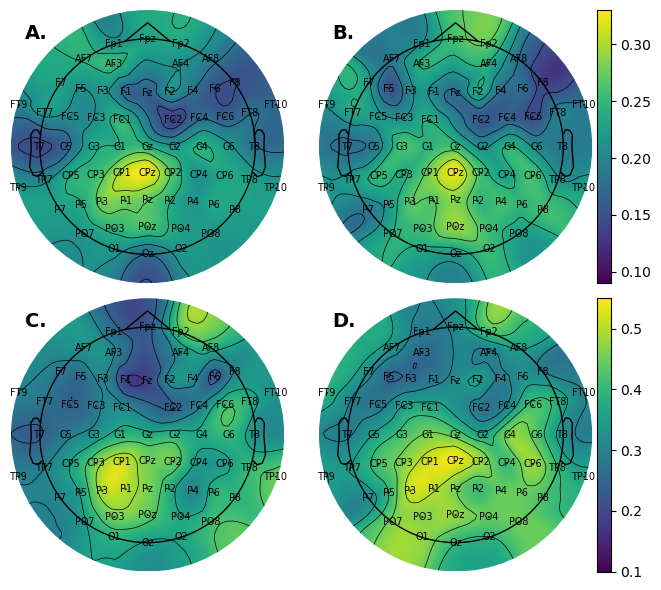

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
vlim1=(.09, .33)
vlim2=(.1, .55)
grouped_corr = all_grid_search_results_unibands.groupby('channel').mean()

plot_on_topomap(grouped_corr['pearson r test'], dataset[0], axes=axes[0,0], vlim=vlim1, plot_bar=False)
axes[0, 0].text(0.05, 0.95, 'A.', transform=axes[0, 0].transAxes,
                             fontsize=14, fontweight='bold', va='top', ha='left')

grouped_corr = all_grid_search_results.groupby('channel').mean()
plot_on_topomap(grouped_corr['pearson r test'], dataset[0], axes=axes[0,1], vlim=vlim1)
axes[0, 1].text(0.05, 0.95, 'B.', transform=axes[0, 1].transAxes,
                             fontsize=14, fontweight='bold', va='top', ha='left')

_= select_grid_results_by_metric(all_grid_search_results,
                                 dataset, corr_cutoff = 0.476, selection_metric = 'pearson val', axes=axes[1,1],
                                 vlim=vlim2)
axes[1, 1].text(0.05, 0.95, 'D.', transform=axes[1, 1].transAxes,
                             fontsize=14, fontweight='bold', va='top', ha='left')
_= select_grid_results_by_metric(all_grid_search_results_unibands,
                                 dataset_unibands, plot_bar=False, corr_cutoff = 0.48, selection_metric = 'pearson val', axes=axes[1,0],
                                 vlim=vlim2)
axes[1, 0].text(0.05, 0.95, 'C.', transform=axes[1, 0].transAxes,
                             fontsize=14, fontweight='bold', va='top', ha='left')
plt.tight_layout()
plt.show()

In [7]:
grouped_corr = all_grid_search_results_unibands.groupby('channel').mean()
grouped_corr['pearson r test'].loc['C3']

np.float64(0.23395283702089867)

In [8]:
interesting_electrodes = ['CP1', 'CPz']

## Results without any clustering

These set a baseline, anything worse than this means the method was pointless

In [9]:
savefile = f'{out_folder}/full_dataset_models_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p'
if not os.path.exists(savefile):
    everything_results = {}
else:
    everything_results = pickle.load(open(savefile, 'rb'))
    
accepted_indexes = []
for s, subj in enumerate(dataset_unibands.dataset):
    if subj['mh_features'].shape[-1] == subj[target_str].shape[-1]:
        accepted_indexes.append(s)
valid_samples = dataset_unibands.get_subsample(accepted_indexes)

for channel in interesting_electrodes:
    if channel not in everything_results:
        common_model_results, _ = mh_common_model(valid_samples, None, channel, target_str)
        everything_results[channel] = common_model_results
pickle.dump(everything_results, open(savefile, 'wb'))


full_dataset_results = []
for electrode, res in everything_results.items():
    for r in res:
        r['electrode'] = electrode
    full_dataset_results.extend(res)
full_dataset_results = pd.DataFrame(full_dataset_results)
full_dataset_results

,pearson r test,pearson p test,MSE test,nMSE test,r2 test,MSE val,r2 val,pearson val,electrode
0,0.227860,5.657075e-16,0.950223,0.951762,0.046696,0.980684,0.016125,0.166636,C3
1,0.108525,1.352995e-04,0.916489,0.954897,0.005085,0.983907,0.012399,0.157779,C3
2,0.073431,9.928870e-03,1.001766,1.000641,0.000482,0.990708,0.005161,0.141400,C3
3,-0.365723,2.761206e-40,1.184615,1.187626,-0.190644,0.977004,0.016713,0.164326,C3
4,-0.154134,5.415581e-08,1.133783,1.126340,-0.118946,0.975618,0.020369,0.173458,C3
...,...,...,...,...,...,...,...,...,...
200,0.503708,3.073575e-80,0.881573,0.878068,0.125422,0.988872,0.004093,0.130627,CP1
201,0.379119,2.143722e-43,0.933919,0.923507,0.086789,0.989974,0.003243,0.126572,CP1
202,0.050443,7.674908e-02,0.986050,1.000681,-0.015529,0.991323,0.003198,0.146203,CP1
203,0.183708,8.197013e-11,0.988965,0.977572,0.033689,0.991323,0.003198,0.146203,CP1


<Axes: xlabel='electrode', ylabel='pearson r test'>

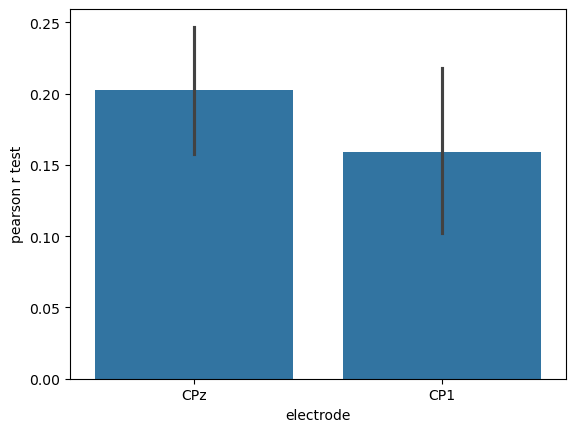

In [10]:
c3_reference = full_dataset_results[full_dataset_results['electrode'] == 'CPz']['pearson r test'].mean()
sns.barplot(data=full_dataset_results[
    (full_dataset_results['electrode'] == 'CPz') |
    (full_dataset_results['electrode'] == 'CP1')
], x='electrode', y='pearson r test')

In [11]:
full_dataset_results[
    (full_dataset_results['electrode'] == 'CPz') |
    (full_dataset_results['electrode'] == 'CP1')
].to_pickle('SMA_bars.pickle')

In [12]:
cpz_general_results = np.array(full_dataset_results[full_dataset_results['electrode'] == 'CPz']['pearson r test'])
cpz_general_results.mean()

np.float64(0.20236005955089706)

In [13]:
to_save = full_dataset_results[full_dataset_results['electrode'] != 'Fp2']
to_save['Target'] = ['SMA'] * len(to_save)
to_save.to_csv('clustering_sma_general.csv', index=False)

## Clustering
We need to precompute the clustering distances if we are using Pearson or corrected Pearson, otherwise we can use the coefficient vectors directly

In [14]:
for run in dataset.dataset:
    if type(run['mh_band_boundaries']) is list:
        run['mh_band_boundaries'] = run['mh_band_boundaries'][0]
for run in dataset_unibands.dataset:
    if type(run['mh_band_boundaries']) is list:
        run['mh_band_boundaries'] = run['mh_band_boundaries'][0]

In [15]:
savefile = f'{out_folder}/clustering_data_b{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p'
from scipy.spatial.distance import euclidean, cityblock, cosine, sqeuclidean, canberra, braycurtis

distances_for_clustering = {
    'l1': cityblock,
    'cosine': cosine,
    'l2': euclidean,
    'canberra': canberra,
    'pearson': correlation_distance,
                           }
if os.path.exists(savefile):
    data_for_clustering = pickle.load(open(savefile, 'rb'))
    _, subjects, _ = get_distance_matrix(dataset, all_models, 'C1', shared_bands)

else:
    data_for_clustering = {
        'interpolation': [],
        'channel': [],
        'distance': [],
        'band sharing': [],
        'precomputed': [],
        'data': [],
    }
    
for interpolation in ['mh', 'interp']:
    for channel in interesting_electrodes:
        for band_sharing in [True, False, 'from start']:
            tdf = pd.DataFrame(data_for_clustering)
            tdf_sel = tdf[
            (tdf['channel'] == channel) &
            (tdf['interpolation'] == interpolation) &
            (tdf['band sharing'] == band_sharing)
            ]
            if len(tdf_sel)>0: continue
                
            data_to_use = dataset_unibands if band_sharing=='from start' else dataset
            models = all_models_unibands if band_sharing=='from start' else all_models
            if band_sharing:
                bands = shared_bands
                shared_channel_names = dataset_unibands[0]['mh_band_boundaries']
            else:
                bands = None
                shared_channel_names = None
            results = get_distance_matrix(
                data_to_use, models, channel, bands, method=interpolation, 
                distance_metric=list(distances_for_clustering.values()),
                fmax=fmax, shared_channel_names = shared_channel_names
            )
            matrices = results[0]

            for distance, matrix in zip(distances_for_clustering.keys(), matrices):
            
                data_for_clustering['interpolation'].append(interpolation)
                data_for_clustering['channel'].append(channel)
                data_for_clustering['distance'].append(distance)
                data_for_clustering['band sharing'].append(band_sharing)
                data_for_clustering['precomputed'].append(True)
                data_for_clustering['data'].append(matrix)
            
            subjects = results[1]
pickle.dump(data_for_clustering, open(savefile, 'wb'))
from datasets.mh_features import get_corr_matrix_distances
from scipy.linalg import logm
from scipy.linalg import sqrtm

def frobenius_dist(a, b):
    return np.linalg.norm(a - b, ord='fro')


method = 'covariance'
for chhh in ['CP1', 'CPz']:
    computed_distances = get_corr_matrix_distances(dataset, all_models,
                                                   distance_metric=lambda a,b: frobenius_dist(logm(a), logm(b)),
                                                   selected_channels=(
                                                       'CP3', 'CP1', 'CPz', 'CP5', 'P5', 'P3', 'P1', 'C3', 'C1', 'Cz',
                                                       'CP2',
                                                   ),
                                                       matrix_type=method,
                                                  )[0]

    data_for_clustering['interpolation'].append('Matrices')
    data_for_clustering['channel'].append(chhh)
    data_for_clustering['distance'].append('Log-Euclidean')
    data_for_clustering['band sharing'].append(method)
    data_for_clustering['precomputed'].append(True)
    data_for_clustering['data'].append(computed_distances)

data_for_clustering = pd.DataFrame(data_for_clustering)

Calculating distance metrics: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 18.98it/s]


In [16]:
data_for_clustering

,interpolation,channel,distance,band sharing,precomputed,data
0,mh,CP1,l1,True,True,"[[0.0, 0.6797387359961649, 0.9137227500261269,..."
1,mh,CP1,cosine,True,True,"[[0.0, 0.3427539585213053, 0.32908593257585206..."
2,mh,CP1,l2,True,True,"[[0.0, 0.03683365505759913, 0.0498309872155037..."
3,mh,CP1,canberra,True,True,"[[0.0, 294.15969011120603, 291.4497750211144, ..."
4,mh,CP1,pearson,True,True,"[[2.220446049250313e-16, 0.3003044054674907, 0..."
...,...,...,...,...,...,...
57,interp,CPz,l2,from start,True,"[[0.0, 0.029229006289395575, 0.043998946192660..."
58,interp,CPz,canberra,from start,True,"[[0.0, 187.54606511362354, 212.2143913668204, ..."
59,interp,CPz,pearson,from start,True,"[[0.0, 0.25484452184739825, 0.2602846861966823..."
60,Matrices,CP1,Log-Euclidean,covariance,True,"[[0.0, 3.105148967637729, 3.5208943457571, 5.1..."


In [17]:
savefile = f'{out_folder}/clustering_search_corr_e{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p'
if os.path.exists(savefile):
    grid_search_clustering_coll = pickle.load(open(savefile, 'rb'))
else:
    grid_search_clustering_coll = []
grid_search_clustering_coll = [k for k in grid_search_clustering_coll if
                               k['metric'][0] != 'Log-Euclidean' and k['channel'][0]!='C1']

linkages = ['average', 'complete', 'single']
for data_index in tqdm.autonotebook.tqdm(range(len(grid_search_clustering_coll), len(data_for_clustering))):
    data_source = data_for_clustering.iloc[data_index]
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            grid_search_clustering_parameters = {
                                                'linkage': [],
                                                'metric': [],
                                                'n clusters': [],
                                                'n selected': [],
                                                'channel': [],
                                                'wcss': [],
                                                'selected elements': [],
                                                'max min distance': [],
                                                'interpolation': [],
                                                'band sharing':[],
                                                }
            channel = data_source['channel']
            interpolation = data_source['interpolation'] # mh or interp
            distance_for_precomputed = data_source['distance']
            band_sharing = data_source['band sharing']
            precomputed = data_source['precomputed']
            data = data_source['data']
            metric = 'precomputed'
            
            for linkage in linkages:
                if band_sharing == 'from start':
                    r = get_trained_model_on_cluster(data, dataset_unibands, linkage, metric, band_sharing, subjects, channel,
                                                    stockwell_save_folder=stockwell_folder,fmax=fmax,
                                                      target_str=target_str,
                                                    )
                else:
                    r = get_trained_model_on_cluster(data, dataset, linkage, metric, band_sharing, subjects, channel,
                                                    stockwell_save_folder=stockwell_folder,fmax=fmax,
                                                      target_str=target_str,
                                                    )
                common_model_results, estimator, wcss, n_clusters, n_to_select, selected_dataset_indices, max_min_distance = r
                
                for result_sample in common_model_results:
                    grid_search_clustering_parameters['linkage'].append(linkage)
                    if not precomputed:
                        grid_search_clustering_parameters['metric'].append(metric)
                    else:
                        grid_search_clustering_parameters['metric'].append(distance_for_precomputed)
                    # grid_search_clustering_parameters['data'].append(data_name)
                    grid_search_clustering_parameters['n clusters'].append(n_clusters)
                    grid_search_clustering_parameters['n selected'].append(n_to_select)
                    grid_search_clustering_parameters['channel'].append(channel)
                    grid_search_clustering_parameters['interpolation'].append(interpolation)
                    grid_search_clustering_parameters['band sharing'].append(band_sharing)
                    grid_search_clustering_parameters['wcss'].append(wcss)
                    grid_search_clustering_parameters['selected elements'].append(selected_dataset_indices)
                    grid_search_clustering_parameters['max min distance'].append(max_min_distance)
                    for result_metric_name, result_metric in result_sample.items():
                        if result_metric_name not in grid_search_clustering_parameters:
                            grid_search_clustering_parameters[result_metric_name] = []
                        grid_search_clustering_parameters[result_metric_name].append(result_metric)
             
            grid_search_clustering_coll.append(grid_search_clustering_parameters)
            
    pickle.dump(grid_search_clustering_coll, open(savefile, 'wb'))

  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
grid_search_clustering_parameters = pd.concat((pd.DataFrame(k) for k in grid_search_clustering_coll), ignore_index=True)
grid_search_clustering_parameters.columns

Index(['linkage', 'metric', 'n clusters', 'n selected', 'channel', 'wcss',
       'selected elements', 'max min distance', 'interpolation',
       'band sharing', 'pearson r test', 'pearson p test', 'MSE test',
       'nMSE test', 'r2 test', 'MSE val', 'r2 val', 'pearson val'],
      dtype='object')

In [19]:
savefile = f'{out_folder}/clustering_search_w_res_corr_e{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p'

if 'OOC pearson r' not in grid_search_clustering_parameters:
    grid_search_clustering_parameters['OOC pearson r'] = None
if os.path.exists(savefile):
    grid_search_clustering_parameters_old = pickle.load(open(savefile, 'rb'))
#     to_remove = grid_search_clustering_parameters_old[grid_search_clustering_parameters_old['metric'] == 'Log-Euclidean'].index
#     grid_search_clustering_parameters_old.loc[to_remove, 'OOC pearson r'] = None
    old_results=grid_search_clustering_parameters_old['OOC pearson r']
    grid_search_clustering_parameters.loc[:len(old_results),'OOC pearson r'] = old_results
    
for clustering_data in tqdm.autonotebook.tqdm(data_for_clustering.iloc, total=len(data_for_clustering)):
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            for linkage in linkages:

                indexes = grid_search_clustering_parameters[
                (grid_search_clustering_parameters['interpolation'] == clustering_data['interpolation']) &
                (grid_search_clustering_parameters['channel'] == clustering_data['channel']) &
                (grid_search_clustering_parameters['metric'] == clustering_data['distance']) &
                    (grid_search_clustering_parameters['linkage'] == linkage) &
                (grid_search_clustering_parameters['band sharing'] == clustering_data['band sharing'])
                ].index
                if len(indexes) == 0: continue
                if len(grid_search_clustering_parameters.loc[indexes, 'OOC pearson r'].dropna()) > 0:
                    continue
                if clustering_data['band sharing'] == 'from start':
                    DDD = dataset_unibands
                else:
                    DDD = dataset

                res = get_trained_model_on_cluster(clustering_data['data'],
                                                                     DDD,
                                                                     linkage,
                                                                     'precomputed',
                                                                     clustering_data['band sharing'],
                                                                     subjects,
                                                                     clustering_data['channel'],
                                                     stockwell_save_folder='Z:\\workdir\\stockwells',
                                                      test_mode=True,
                                                      target_str=target_str,
                                                     fmax=fmax,
                                                     # max_iterations=1000000000,
                                                                     )


                grid_search_clustering_parameters.loc[indexes, 'OOC pearson r'] = np.average([k['pearson r'] for k in res])
pickle.dump(grid_search_clustering_parameters, open(savefile, 'wb'))
grid_search_clustering_parameters

  0%|          | 0/62 [00:00<?, ?it/s]

,linkage,metric,n clusters,n selected,channel,wcss,selected elements,max min distance,interpolation,band sharing,pearson r test,pearson p test,MSE test,nMSE test,r2 test,MSE val,r2 val,pearson val,OOC pearson r
0,average,l1,6,10,CP1,15.664724,"[0, 1, 22, 3, 42, 24, 8, 18, 41, 27]",0.847791,mh,True,0.127551,7.094697e-06,0.986089,0.987687,0.010713,1.063896,-0.072635,0.049509,0.229451
1,average,l1,6,10,CP1,15.664724,"[0, 1, 22, 3, 42, 24, 8, 18, 41, 27]",0.847791,mh,True,0.386706,3.193388e-45,0.835816,0.870843,0.092662,1.053674,-0.056181,0.079586,0.229451
2,average,l1,6,10,CP1,15.664724,"[0, 1, 22, 3, 42, 24, 8, 18, 41, 27]",0.847791,mh,True,0.189665,1.927034e-11,0.992695,0.979108,0.034292,0.998183,-0.015312,0.167595,0.229451
3,average,l1,6,10,CP1,15.664724,"[0, 1, 22, 3, 42, 24, 8, 18, 41, 27]",0.847791,mh,True,-0.064743,2.305431e-02,1.069298,1.072015,-0.074739,1.015244,-0.031280,0.128354,0.229451
4,average,l1,6,10,CP1,15.664724,"[0, 1, 22, 3, 42, 24, 8, 18, 41, 27]",0.847791,mh,True,0.072654,1.074366e-02,1.020952,1.009191,0.002435,1.036527,-0.054949,0.102698,0.229451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1836,single,Log-Euclidean,19,8,CPz,26.203824,"[3, 4, 11, 12, 13, 32, 33, 34]",4.925361,Matrices,covariance,-0.181343,1.437425e-10,1.344933,1.330741,-0.316699,0.914224,0.082203,0.357176,-0.069649
1837,single,Log-Euclidean,19,8,CPz,26.203824,"[3, 4, 11, 12, 13, 32, 33, 34]",4.925361,Matrices,covariance,-0.178360,2.888131e-10,1.085289,1.140470,-0.198456,0.962073,0.008365,0.302941,-0.069649
1838,single,Log-Euclidean,19,8,CPz,26.203824,"[3, 4, 11, 12, 13, 32, 33, 34]",4.925361,Matrices,covariance,-0.029631,2.987026e-01,1.059230,1.066706,-0.074236,0.952007,0.033584,0.264061,-0.069649
1839,single,Log-Euclidean,19,8,CPz,26.203824,"[3, 4, 11, 12, 13, 32, 33, 34]",4.925361,Matrices,covariance,-0.035969,2.070810e-01,1.052727,1.065152,-0.077724,0.952007,0.033584,0.264061,-0.069649


In [20]:
set(grid_search_clustering_parameters['channel'])

{'CP1', 'CPz'}

In [21]:
def fix_dataframe(df):
    """Ensure all string entries and column names start with an uppercase character."""
    df.columns = [col.capitalize() if 'OOC' not in col else col for col in df.columns]
    df['Band sharing'] = df['Band sharing'].astype(str)
    for col in ['Metric', 'Interpolation', 'Band sharing', 'Linkage', ]:
        df[col] = df[col].str.capitalize()
    df['Interpolation'] = df['Interpolation'].replace('Mh', 'MH')
    df['Interpolation'] = df['Interpolation'].replace('Interp', 'Linear')
    df['Metric'] = df['Metric'].replace('Log-euclidean', 'Log-Euclidean')
    df['Band sharing'] = df['Band sharing'].replace('True', 'Shared')
    df['Band sharing'] = df['Band sharing'].replace('False', 'Paired')
    df['Band sharing'] = df['Band sharing'].replace('From start', 'Origin')
    return df

In [22]:
grid_search_clustering_parameters = fix_dataframe(grid_search_clustering_parameters)

In [23]:
grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Linkage'] == 'Average') &
    (grid_search_clustering_parameters['Metric'] == 'Log-Euclidean')
]['Pearson r test'].mean()

np.float64(0.18418244054095728)

Text(0.5, 1.0, 'SMA: IC correlation by linkage and metric')

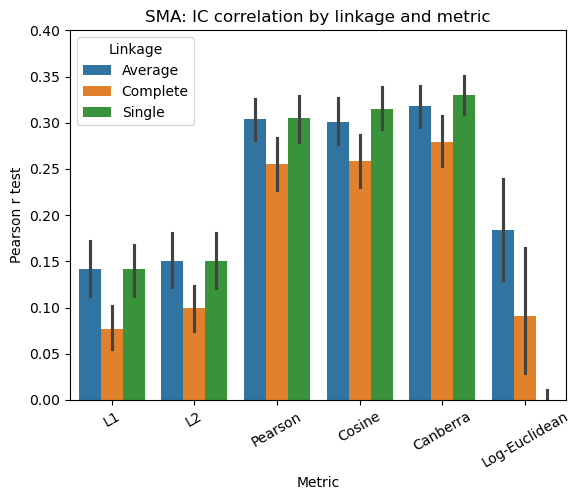

In [24]:
sns.barplot(data=grid_search_clustering_parameters, y='Pearson r test', x = 'Metric', hue='Linkage', 
            order=['L1', 'L2', 'Pearson', 'Cosine', 'Canberra', 'Log-Euclidean']
           )
plt.ylim(0, 0.4)
plt.xticks(rotation=30)
plt.title('SMA: IC correlation by linkage and metric')

Text(0.5, 1.0, 'SMA: Within-cluster correlation')

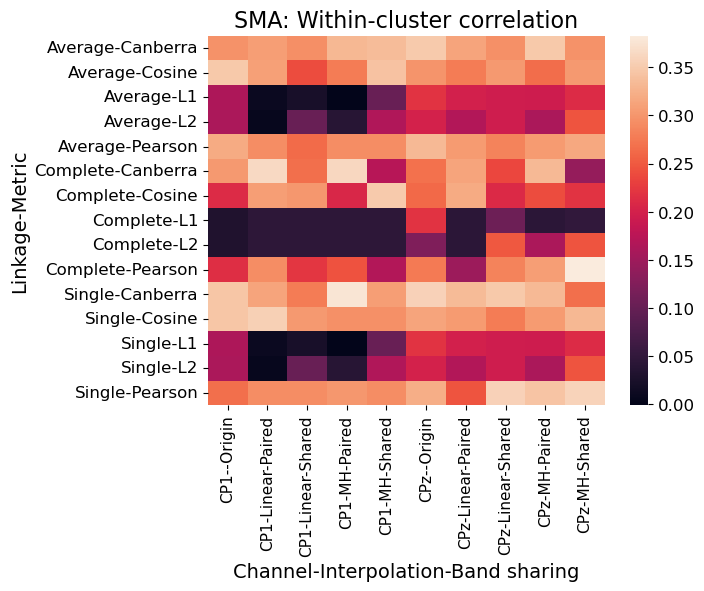

In [25]:
plt.rcParams.update({
    'axes.titlesize': 16,    # Title
    'axes.labelsize': 14,    # Axis labels
    'xtick.labelsize': 11,   # X-axis ticks
    'ytick.labelsize': 12,   # Y-axis ticks
    'legend.fontsize': 12    # Legend
})

test_copy = grid_search_clustering_parameters.copy()
test_copy = test_copy[test_copy['Interpolation'] != 'Matrices']
test_copy.loc[test_copy['Band sharing'] == 'Origin', 'Interpolation'] = ''
pivot_df = test_copy.pivot_table(
    index=['Linkage', 'Metric'],
    columns=['Channel', 'Interpolation', 'Band sharing'],
    values='Pearson r test'
)

# Drop 'mh' under 'from start'
pivot_df = pivot_df.drop(columns=[k for k in pivot_df.columns if 'from start' in k and 'mh' in k])

# Rename 'interp' to ''
pivot_df = pivot_df.rename({
    ('Drom start', 'Interp', 'Fp2'): ('From start', '', 'Fp2')
}, axis='columns'
)
sns.heatmap(pivot_df)
np.array(pivot_df).max()
plt.title('SMA: Within-cluster correlation')

In [26]:
elm = grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Canberra') &
    (grid_search_clustering_parameters['Linkage'] == 'Complete') &
    (grid_search_clustering_parameters['Channel'] == 'CP1') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Paired')
]['Selected elements'].iloc[0]
len(set([f"{dataset[k]['subj']}" for k in elm]))

5

In [27]:
cp1_best_c = np.array(grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Canberra') &
    (grid_search_clustering_parameters['Linkage'] == 'Single') &
    (grid_search_clustering_parameters['Channel'] == 'CP1') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Paired')
]['Pearson r test'])
print(cp1_best_c.mean())

0.37689464226406877


In [28]:
og_model = np.array(grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Pearson') &
    (grid_search_clustering_parameters['Linkage'] == 'Average') &
    (grid_search_clustering_parameters['Channel'] == 'CPz') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Shared')
]['Pearson r test'])
print(og_model.mean())

0.3165063404332413


In [29]:
from mlxtend.evaluate import permutation_test

permutation_test(og_model, cp1_best_c,
                           method='approximate',
                           num_rounds=10000,
                           seed=42)

0.29357064293570645

In [30]:
c1_best_c = np.array(grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Canberra') &
    (grid_search_clustering_parameters['Linkage'] == 'Average') &
    (grid_search_clustering_parameters['Channel'] == 'CP3') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Shared')
]['Pearson r test'])
print(c1_best_c.mean())

nan


/tmp/ipykernel_46018/1243420254.py:8: RuntimeWarning: Mean of empty slice.
  print(c1_best_c.mean())
/home/riccardo/anaconda3/envs/EEG-fMRI/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 1.0, 'SMA: OOC correlation')

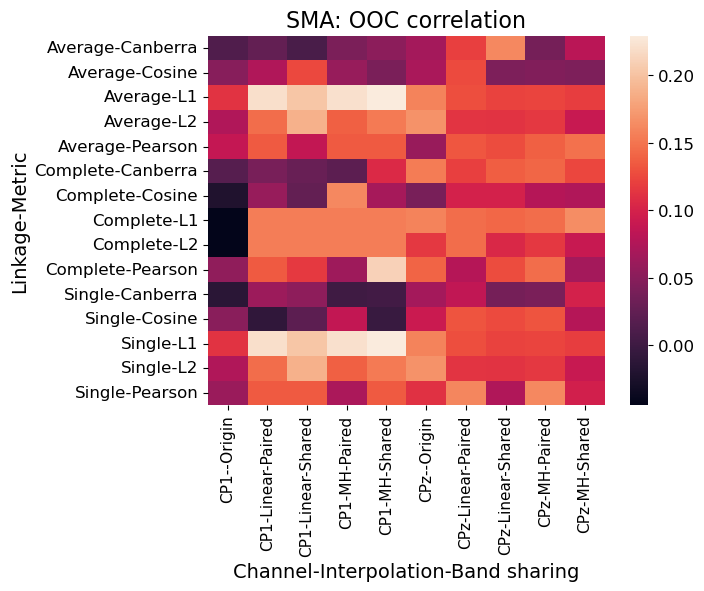

In [31]:
test_copy = grid_search_clustering_parameters.copy()
test_copy = test_copy[test_copy['Interpolation'] != 'Matrices']
test_copy.loc[
    (test_copy['Band sharing'] == 'Origin') &
    (test_copy['Interpolation'] == 'Linear'),
    'Interpolation'] = ''
pivot_df = test_copy.pivot_table(
    index=['Linkage', 'Metric'],
    columns=['Channel', 'Interpolation', 'Band sharing'],
    values='OOC pearson r'
)

# Drop 'mh' under 'from start'
pivot_df = pivot_df.drop(columns=[k for k in pivot_df.columns if 'Origin' in k and 'MH' in k])

# Rename 'interp' to ''
pivot_df = pivot_df.astype(float)
sns.heatmap(pivot_df)
np.array(pivot_df).max()
plt.title('SMA: OOC correlation')

In [32]:
pivot_df

Channel                 CP1                                               CPz  \
Interpolation                  Linear                  MH                       
Band sharing         Origin    Paired    Shared    Paired    Shared    Origin   
Linkage  Metric                                                                 
Average  Canberra  0.012979  0.025862  0.008607  0.041826  0.052389  0.067980   
         Cosine    0.049069  0.075097  0.125136  0.059109  0.041048  0.070800   
         L1        0.112892  0.220263  0.201973  0.221633  0.229451  0.158079   
         L2        0.074928  0.145695  0.188161  0.137536  0.152568  0.167856   
         Pearson   0.088290  0.134524  0.087228  0.134524  0.134524  0.059835   
Complete Canberra  0.017243  0.039476  0.028757  0.020956  0.106393  0.153833   
         Cosine   -0.021392  0.058825  0.025682  0.161997  0.068477  0.039619   
         L1       -0.044283  0.155335  0.155335  0.155335  0.155335  0.158079   
         L2       -0.044283  0.155335  0.155335  0.155335  0.155335  0.115347   
         Pearson   0.054619  0.134524  0.116798  0.062826  0.210493  0.140278   
Single   Canberra -0.013861  0.061892  0.053980  0.001670  0.003407  0.067980   
         Cosine    0.050016 -0.009720  0.021888  0.086396 -0.002879  0.091597   
         L1        0.112892  0.220263  0.201973  0.221633  0.229451  0.158079   
         L2        0.074928  0.145695  0.188161  0.137536  0.152568  0.167856   
         Pearson   0.060860  0.134524  0.134524  0.071748  0.134524  0.111506   

Channel                                                    
Interpolation        Linear                  MH            
Band sharing         Paired    Shared    Paired    Shared  
Linkage  Metric                                            
Average  Canberra  0.120128  0.161716  0.037033  0.081324  
         Cosine    0.126114  0.042379  0.044964  0.042379  
         L1        0.128581  0.121507  0.122914  0.119014  
         L2        0.113447  0.112638  0.115468  0.089870  
         Pearson   0.132157  0.127786  0.138078  0.147318  
Complete Canberra  0.120128  0.136674  0.141710  0.123623  
         Cosine    0.099351  0.099561  0.078289  0.075111  
         L1        0.145981  0.142173  0.145981  0.164699  
         L2        0.145981  0.104719  0.115468  0.089870  
         Pearson   0.078300  0.127786  0.146001  0.067983  
Single   Canberra  0.085421  0.037033  0.040536  0.099784  
         Cosine    0.131889  0.126114  0.131889  0.078066  
         L1        0.128581  0.121507  0.122914  0.119014  
         L2        0.113447  0.112638  0.115468  0.089870  
         Pearson   0.160587  0.074662  0.161810  0.097728

Text(0.5, 1.0, 'SMA: IC correlation, select clusters')

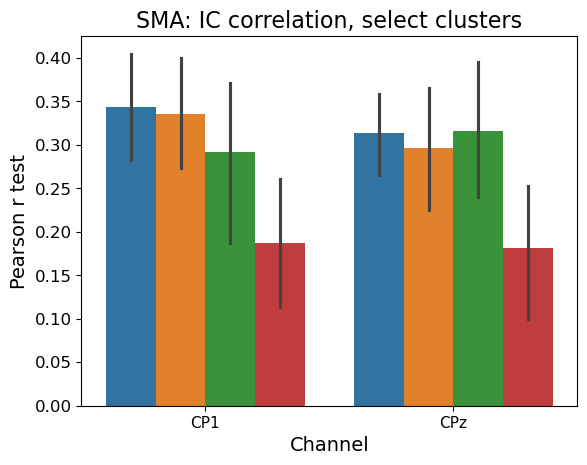

In [33]:
sns.barplot(data=pd.concat((grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Cosine') &
    (grid_search_clustering_parameters['Linkage'] == 'Single') &
    (grid_search_clustering_parameters['Band sharing'] == 'Origin')
],
                            grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Canberra') &
    (grid_search_clustering_parameters['Linkage'] == 'Average') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Shared')
],
                                                        grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Pearson') &
    (grid_search_clustering_parameters['Linkage'] == 'Average') &
    (grid_search_clustering_parameters['Interpolation'] == 'MH') &
    (grid_search_clustering_parameters['Band sharing'] == 'Shared')
],
                            
                                                        grid_search_clustering_parameters[
    (grid_search_clustering_parameters['Metric'] == 'Log-Euclidean') &
    (grid_search_clustering_parameters['Linkage'] == 'Average')
]
                            
                           )), y = 'Pearson r test', x='Channel', hue='Metric', legend=False)

plt.title('SMA: IC correlation, select clusters')